# Import Packages

In [1]:
from utils import draw_results

import mne
from mne.stats import fdr_correction
import matplotlib.pyplot as plt
from pylab import mpl
from scipy import stats
import numpy as np
import dill

In [2]:
plt.rcParams['font.family']=['Arial','serif', 'Times New Roman']
plt.style.use('default')
mpl.rcParams["axes.unicode_minus"] = False
%config InlineBackend.figure_format = 'svg'

# Load Data

In [ ]:

pic_eeg_data_list = []
icon_eeg_data_list = []
text_eeg_data_list = []

file_path = "../data/EEG/Subject_"

for subject in range(1, 25):

    file = file_path + str(subject) + '_epo.fif'        
    epochs = mne.read_epochs(file, preload=True)
    subject -= 1

    epochs = epochs.crop(tmin=0.0, tmax=1.0)

    events_dict = { }

    for sym in ['pic', 'icon', 'text']: # 3 symbol types
        for c in range(1, 7): # 6 concepts
            events_dict[sym+str(c)] = []

    for id in epochs.event_id:
        # id : ab-cd-e-f-ghi
        # a : symbol type of first stimulus (1 for picture, 2 for icon, 3 for text)
        # b : concept of first stimulus (1-6 for scooter-train)
        # c : symbol type of second stimulus (1 for picture, 2 for icon, 3 for text)
        # d : concept of second stimulus (1-6 for scooter-train)

        lab = ['', 'pic', 'icon', 'text']
        for sym in range(1, 4): # 3 symbol types
            for c in range(1, 7): # 6 concepts
                if id[0]==str(sym) and id[1]==str(c):
                    events_dict[lab[sym]+str(c)].append(id)

    sym = 'pic'
    for c in range(1, 7): # 6 concepts
        eeg_data = epochs[events_dict[sym+str(c)]].get_data(copy=True); # [61, 501]
        if subject == 0:
            pic_eeg_data_list.append( eeg_data )
        else:
            pic_eeg_data_list[c-1] = np.vstack( (pic_eeg_data_list[c-1], eeg_data) )

    sym = 'icon'
    for c in range(1, 7): # 6 concepts
        eeg_data = epochs[events_dict[sym+str(c)]].get_data(copy=True); # [61, 501]
        if subject == 0:
            icon_eeg_data_list.append( eeg_data )
        else:
            icon_eeg_data_list[c-1] = np.vstack( (icon_eeg_data_list[c-1], eeg_data) )

    sym = 'text'
    for c in range(1, 7): # 6 concepts
        eeg_data = epochs[events_dict[sym+str(c)]].get_data(copy=True); # [61, 501]
        if subject == 0:
            text_eeg_data_list.append( eeg_data )
        else:
            text_eeg_data_list[c-1] = np.vstack( (text_eeg_data_list[c-1], eeg_data) )


# ANOVA Function for Each Channel and Each Timepoint

In [4]:
def one_way_anova(eeg_data):
    
    res_p = np.zeros((61, 501))
    res_f = np.zeros((61, 501))

    for ch in range(61):
        for t in range(501):
            
            data = []
            for eeg in eeg_data:
                data.append(eeg[:, ch, t])
            
            res_f[ch,t], res_p[ch, t] = stats.f_oneway(*data)

    # FDR Correction
    _, corr_p = fdr_correction(res_p, alpha=0.05, method="indep") # [61, 501]

    return res_f, corr_p

# ANOVA for concepts in Picture

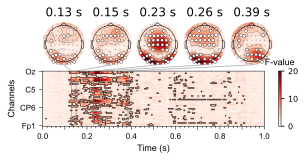

In [5]:
f_val, corr_p_val =  one_way_anova(pic_eeg_data_list)

fake_evk = mne.EvokedArray( f_val, epochs.info, tmin=0 )
fake_evk.nave = None
fake_evk.set_montage(epochs.get_montage());

draw_results.plot_topomap_joint(fake_evk, corr_p_val<0.01, figsize=(5, 2), units='F-value',
                           vmin=0, vmax=20.0, cmap="Reds", minor_tick=0.02, 
                           time_points=[0.13, 0.15, 0.23, 0.26, 0.385])

In [6]:
erp = np.sum(corr_p_val < 0.05, axis=0)

with open('./anova_p_num_picture.pkl', 'wb') as f:
    dill.dump(erp, f)

# ANOVA for concepts in Icon

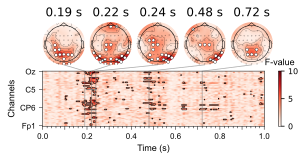

In [7]:
f_val, corr_p_val =  one_way_anova(icon_eeg_data_list)

fake_evk = mne.EvokedArray( f_val, epochs.info, tmin=0 )
fake_evk.nave = None
fake_evk.set_montage(epochs.get_montage());

draw_results.plot_topomap_joint(fake_evk, corr_p_val<0.05, figsize=(5, 2), units='F-value',
                           vmin=0, vmax=10.0, cmap="Reds", minor_tick=0.02, 
                           time_points=[0.19, 0.22, 0.24, 0.48, 0.72])

In [8]:
erp = np.sum(corr_p_val < 0.05, axis=0)

with open('./anova_p_num_icon.pkl', 'wb') as f:
    dill.dump(erp, f)

# ANOVA for concepts in Text

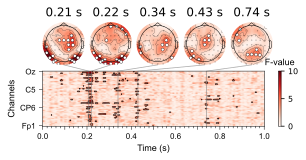

In [16]:
f_val, corr_p_val =  one_way_anova(text_eeg_data_list)

fake_evk = mne.EvokedArray( f_val, epochs.info, tmin=0 )
fake_evk.nave = None
fake_evk.set_montage(epochs.get_montage());

draw_results.plot_topomap_joint(fake_evk, corr_p_val<0.05, figsize=(5, 2), units='F-value',
                           vmin=0, vmax=10.0, cmap="Reds", minor_tick=0.02, 
                           time_points=[0.208, 0.22, 0.34, 0.43, 0.74])

In [10]:
erp = np.sum(corr_p_val < 0.05, axis=0)

with open('./anova_p_num_text.pkl', 'wb') as f:
    dill.dump(erp, f)